In [1]:
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
# import ardent
import time
import os
import pandas as pd

# from proglearn.progressive_learner import ProgressiveLearner
# from proglearn.deciders import SimpleArgmaxAverage
# from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
# from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims.gaussian_sim import _generate_2d_rotation
from proglearn.sims import generate_spirals
from proglearn.forest import LifelongClassificationForest

import pandas as pd
import SimpleITK as sitk
from sklearn.neighbors import BallTree

In [25]:
context = sns.plotting_context(context="poster", font_scale=1)
sns.set_context(context)

In [60]:
def grid_to_pred(task_pos_reshaped, test_task, xx, yy):
    pred = np.empty((len(test_task), ))

    for i in range(len(test_task)):
        x_ind = np.where(test_task[i,0] <= xx[0,:])[0][0]
        y_ind = np.where(test_task[i,1] <= yy[:,0])[0][0]
        pred[i] = task_pos_reshaped[y_ind, x_ind]

    pred = pred.reshape((-1,1))
    pred = np.hstack((pred, 1-pred))
    pred = np.argmax(pred, axis=1)
    
    return pred

In [61]:
def rotated_spirals(n_samples, n_class=2, noise=0.3, angle=0):
    X,y = generate_spirals(n_samples=n_samples, n_class=n_class, noise=noise)
    if angle is not 0:
        R = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
        X = X @ R
    return X, y

In [62]:
radius = 1.2
def to_grid_in_cir(test_task1, test_task2, radius=radius):
    h = 0.01
    x_min1, x_max1 = test_task1[:,0].min(), test_task1[:,0].max()
    y_min1, y_max1 = test_task1[:,1].min(), test_task1[:,1].max()
    x_min2, x_max2 = test_task2[:,0].min(), test_task2[:,0].max()
    y_min2, y_max2 = test_task2[:,1].min(), test_task2[:,1].max()

    x_min = min(x_min1, x_min2) - 0.1
    x_max = max(x_max1, x_max2) + 0.1
    y_min = min(y_min1, y_min2) - 0.1
    y_max = max(y_max1, y_max2) + 0.1
    x, y = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    r = np.sqrt(x**2 + y**2)  # centered at (0,0)
    inside = r <= radius  # radius of 1
    x_cir = x[inside]  # can also use np.ma.masked_less_equal(r,1).data
    y_cir = y[inside]
    return x, y, inside, np.array([x_cir, y_cir]).T

In [63]:
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

In [64]:
# def init_forest(max_depth):
#     np.random.seed(1)
#     default_transformer_class = TreeClassificationTransformer
#     default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

#     default_voter_class = TreeClassificationVoter
#     default_voter_kwargs = {}

#     default_decider_class = SimpleArgmaxAverage
#     default_decider_kwargs = {"classes" : np.arange(2)}
#     progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
#                                             default_transformer_kwargs = default_transformer_kwargs,
#                                             default_voter_class = default_voter_class,
#                                             default_voter_kwargs = default_voter_kwargs,
#                                             default_decider_class = default_decider_class,
#                                             default_decider_kwargs = default_decider_kwargs)
#     uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
#                                             default_transformer_kwargs = default_transformer_kwargs,
#                                             default_voter_class = default_voter_class,
#                                             default_voter_kwargs = default_voter_kwargs,
#                                             default_decider_class = default_decider_class,
#                                             default_decider_kwargs = default_decider_kwargs)
#     return progressive_learner, uf

In [64]:
def generate_posteriors(X, task_id, forest, transformers):
    vote_per_transformer_id = []
    for transformer_id in transformers:
        vote_per_bag_id = []
        for bag_id in range(
            len(forest.pl_.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id])
        ):
            transformer = forest.pl_.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id][
                bag_id
            ]
            X_transformed = transformer.transform(X)
            voter = forest.pl_.task_id_to_decider[task_id].transformer_id_to_voters_[transformer_id][bag_id]
            vote = voter.predict_proba(X_transformed)
            vote_per_bag_id.append(vote)
        vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

    return vote_per_transformer_id

In [65]:
def box_to_cir(data, radius=radius):
    X = data[0]
    y = data[1]
    X_cir = []
    y_cir = []
    for i in range(len(X)):
        if (X[i,0]**2 + X[i,1]**2 <= radius):
            X_cir.append(X[i,:])
            y_cir.append(y[i])
    return np.array(X_cir).reshape(-1,2), np.array(y_cir).reshape(-1)

In [28]:
def run_elastix(task1pred1_reshaped, task2pred2_reshaped, res, ite, scale):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(task1pred1_reshaped))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(task2pred2_reshaped))
    elastixImageFilter.LogToFileOn()
    ParamMap = sitk.GetDefaultParameterMap('affine')    
    ParamMap['AutomaticTransformInitialization'] = ['false']
    ParamMap['AutomaticTransformInitializationMethod'] = ['GeometricalCenter']
    ParamMap['Metric'] = ['AdvancedNormalizedCorrelation']
    ParamMap['MaximumNumberOfIterations'] = [ite]
    
#     ParamMap['MaximumNumberOfSamplingAttempts'] = ['4']
#     ParamMap['AutomaticScalesEstimation'] = ['false']
#     ParamMap['UseRandomSampleRegion'] = ['true']
#     ParamMap['SampleRegionSize'] = ['100','100']
#     ParamMap['MaximumNumberOfSamplingAttempts'] = ['10']
#     ParamMap['MaximumStepLength'] = ['0.5']
#     ParamMap['AutomaticParameterEstimation'] = ['false']
    ParamMap['Transform'] = ['EulerTransform']
#     ParamMap['AutomaticTransformInitialization'] = ['true']
    ParamMap['NumberOfResolutions'] = [res]
    ParamMap['MaximumStepLength'] = ['1.0']
    ParamMap['ImageSampler'] = ['Random']
    ParamMap['SP_alpha'] = ['0.6']
    ParamMap['SP_A'] = ['50']
    ParamMap['NewSamplesEveryIteration'] = ['true']
    ParamMap['FixedImagePyramid'] = ['FixedRecursiveImagePyramid']
    ParamMap["MovingImagePyramid"] = ["MovingRecursiveImagePyramid"] 
    ParamMap['UseDirectionCosines'] = ['true']
    
    ParamMap['Scales'] = [scale]
    ParamMap['AutomaticScalesEstimation'] = ['false']
#     ParamMap['BSplineInterpolationOrder'] = ['3']

    # Set the parameter map:
    elastixImageFilter.SetParameterMap(ParamMap)

    # Register the 2D images:
    elastixImageFilter.Execute()

    # Get the registered image:
    RegIm = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
#     params = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
    
    return RegIm

In [29]:
def params_to_mat(params):
    init_affines = np.eye(3)
    init_affines[0,:2] = [float(params[0]), float(params[2])]
    init_affines[1,:2] = [float(params[1]), float(params[3])]
    init_affines[2,:2] = [float(params[4]), float(params[5])]
    return init_affines.T

In [30]:
def reshape_posteriors(inside, task):
    inside_ravel = inside.ravel()
    preds = np.zeros(inside_ravel.shape)
    j = 0
    for i in range(len(inside_ravel)):
        if inside_ravel[i]:
            preds[i] = task[j]
            j += 1
    preds = preds.reshape(inside.shape)
    
    return preds

In [31]:
def vote_to_pred(vote, test_task, test_grid):
    tree = BallTree(test_grid)
    pred = np.zeros(test_task.shape)
    for i in range(len(test_task)):
        _, ind = tree.query(test_task[i,:].reshape(-1,2), k=1)
        pred[i,0] = vote[ind]
        pred[i,1] = 1 - pred[i,0]
        
    return pred

#### compute errors

In [32]:
def exp(n_task1, n_task2, task2_angle, task1_angle=0, n_test=1000, n_trees=10, ite=500, res=4, scale=100):
    #source data
    X_task1, y_task1 = box_to_cir(rotated_spirals(n_task1, 2, 0.8, task1_angle))
    test_task1, test_label_task1 = box_to_cir(rotated_spirals(n_test, 2, 0.8, task1_angle))

    #target data
    X_task2, y_task2 = box_to_cir(rotated_spirals(n_task2, 2, 0.8, task2_angle))
    test_task2, test_label_task2 = box_to_cir(rotated_spirals(n_test,  2, 0.8, task2_angle))
    xx, yy, inside, test_grid = to_grid_in_cir(test_task1, test_task2)

    l2f = LifelongClassificationForest(default_n_estimators=n_trees)
    uf1 = LifelongClassificationForest(default_n_estimators=n_trees)

    l2f.add_task(X_task1, y_task1, n_estimators=n_trees)
    l2f.add_task(X_task2, y_task2, n_estimators=n_trees)
    uf1.add_task(X_task1, y_task1, n_estimators=2*n_trees)

    l2f_task1 = generate_posteriors(test_grid, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(test_grid, 1, l2f, [0,1])

    task1pred1_reshaped = reshape_posteriors(inside, l2f_task1[0][:,0])
    task1pred2_reshaped = reshape_posteriors(inside, l2f_task1[1][:,0])
    task2pred1_reshaped = reshape_posteriors(inside, l2f_task2[0][:,0])
    task2pred2_reshaped = reshape_posteriors(inside, l2f_task2[1][:,0])

    uf_task1 = generate_posteriors(test_grid, 0, uf1, [0])
    task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1[0][:,0])

    errors = np.zeros(3, dtype=float)
    vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside].ravel()
    pred1 = vote_to_pred(vote1, test_task1, test_grid)
    errors[0] = 1-np.mean(np.argmax(pred1, axis=1) == test_label_task1)

    vote3 = task1pred1_reshaped_uf[inside].ravel()
    pred3 = vote_to_pred(vote3, test_task1, test_grid)
    errors[2] = 1-np.mean(np.argmax(pred3, axis=1) == test_label_task1)
    
    if task2_angle != 0:
        try:
            # run elastix
            task1pred1_deformed = run_elastix(
                    task1pred1_reshaped, task2pred2_reshaped, str(res), str(ite), str(scale)
                )

            vote2 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside].ravel()
            pred2 = vote_to_pred(vote2, test_task1, test_grid)
            errors[1] = 1-np.mean(np.argmax(pred2, axis=1) == test_label_task1)
        except:
            errors[1] = np.nan
    
    return errors

In [19]:
exp(750, 750, task2_angle=np.pi*(0/180), ite=1500, res=4, scale=100)

array([0.105, 0.   , 0.131])

In [67]:
n_task1=750; n_task2=750; n_test=1000; n_trees=10; task2_angle=np.pi*(180/180); task1_angle=0
errors=np.zeros(3, dtype=float)

#source data
X_task1, y_task1 = box_to_cir(rotated_spirals(n_task1, 2, 0.8, task1_angle))
test_task1, test_label_task1 = box_to_cir(rotated_spirals(n_test, 2, 0.8, task1_angle))

#target data
X_task2, y_task2 = box_to_cir(rotated_spirals(n_task2, 2, 0.8, task2_angle))
test_task2, test_label_task2 = box_to_cir(rotated_spirals(n_test,  2, 0.8, task2_angle))
xx, yy, inside, test_grid = to_grid_in_cir(test_task1, test_task2)

l2f = LifelongClassificationForest(default_n_estimators=n_trees)
uf1 = LifelongClassificationForest(default_n_estimators=n_trees)

l2f.add_task(X_task1, y_task1, n_estimators=n_trees)
l2f.add_task(X_task2, y_task2, n_estimators=n_trees)
uf1.add_task(X_task1, y_task1, n_estimators=2*n_trees)

l2f_task1 = generate_posteriors(test_grid, 0, l2f, [0,1])
l2f_task2 = generate_posteriors(test_grid, 1, l2f, [0,1])

task1pred1_reshaped = reshape_posteriors(inside, l2f_task1[0][:,0])
task1pred2_reshaped = reshape_posteriors(inside, l2f_task1[1][:,0])
task2pred1_reshaped = reshape_posteriors(inside, l2f_task2[0][:,0])
task2pred2_reshaped = reshape_posteriors(inside, l2f_task2[1][:,0])

uf_task1 = generate_posteriors(test_grid, 0, uf1, [0])
task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1[0][:,0])

errors = np.zeros(3, dtype=float)
vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside].ravel()
pred1 = vote_to_pred(vote1, test_task1, test_grid)
errors[0] = 1-np.mean(np.argmax(pred1, axis=1) == test_label_task1)

vote3 = task1pred1_reshaped_uf[inside].ravel()
pred3 = vote_to_pred(vote3, test_task1, test_grid)
errors[2] = 1-np.mean(np.argmax(pred3, axis=1) == test_label_task1)

NameError: name 'reshape_posteriors' is not defined

In [50]:
# run elastix
task1pred1_deformed = run_elastix(
        task1pred1_reshaped, task2pred2_reshaped, '4', '1000', '20'
    )
vote2 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside].ravel()
pred2 = vote_to_pred(vote2, test_task1, test_grid)
errors[1] = 1-np.mean(np.argmax(pred2, axis=1) == test_label_task1)
errors

array([0.09 , 0.089, 0.084])

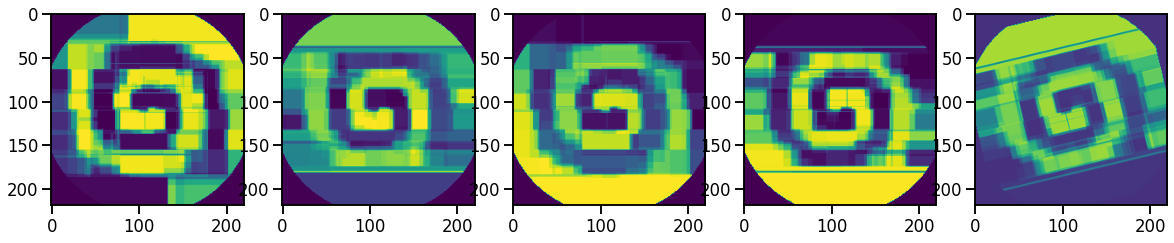

In [49]:
fig,axs = plt.subplots(1,5,figsize=(20,4))
axs[0].imshow(task1pred1_reshaped)
axs[1].imshow(task1pred2_reshaped)
axs[2].imshow(task2pred1_reshaped)
axs[3].imshow(task2pred2_reshaped)
axs[4].imshow(task1pred1_deformed)
# plt.colorbar()
plt.show()

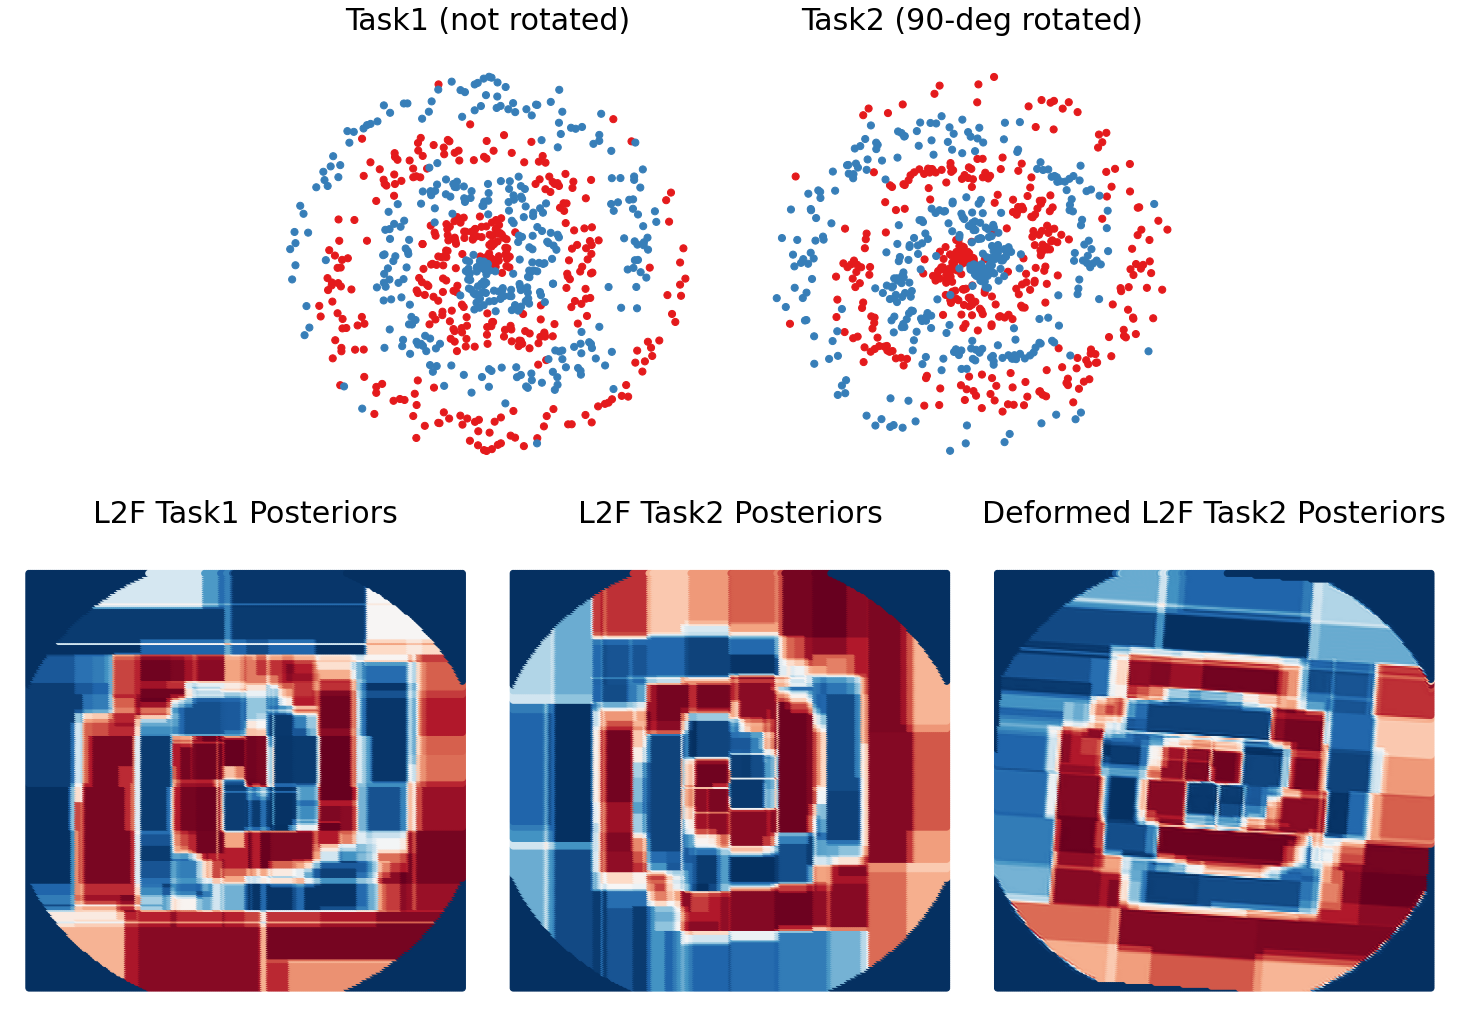

In [48]:
fig = plt.figure(constrained_layout=True,figsize=(21,14))
gs = fig.add_gridspec(12, 21)
ax1 = fig.add_subplot(gs[6:,:6])
ax1.scatter(xx,yy,c=task1pred1_reshaped, cmap='RdBu_r',vmin=0,vmax=1)
ax1.set_title('L2F Task1 Posteriors', fontsize=30, pad=30); ax1.axis('off'); ax1.set_xticks([]); ax1.set_yticks([])
ax1 = fig.add_subplot(gs[6:,7:13])
ax1.scatter(xx,yy,c=task2pred2_reshaped, cmap='RdBu_r',vmin=0,vmax=1)
ax1.set_title('L2F Task2 Posteriors', fontsize=30, pad=30); ax1.axis('off'); ax1.set_xticks([]); ax1.set_yticks([])
ax1 = fig.add_subplot(gs[6:,14:-1])
ax1.scatter(xx,yy,c=task1pred1_deformed, cmap='RdBu_r',vmin=0,vmax=1)
ax1.set_title('Deformed L2F Task2 Posteriors', fontsize=30, pad=30); ax1.axis('off'); ax1.set_xticks([]); ax1.set_yticks([])

ax = fig.add_subplot(gs[:6,4:10])
clr = [colors[i] for i in y_task1]
ax.scatter(X_task1[:, 0], X_task1[:, 1], c=clr, s=50)
ax.set_xlim([-1.2,1.2]); ax.set_ylim([-1.2,1.2])
ax.set_xticks([]); ax.set_yticks([]); ax.axis('off')
ax.set_title('Task1 (not rotated)', fontsize=30)
ax = fig.add_subplot(gs[:6,10:16])
clr = [colors[i] for i in y_task2]
ax.scatter(X_task2[:, 0], X_task2[:, 1], c=clr, s=50)
ax.set_xlim([-1.2,1.2]); ax.set_ylim([-1.2,1.2])
ax.set_xticks([]); ax.set_yticks([]); ax.axis('off')
ax.set_title('Task2 (90-deg rotated)', fontsize=30)
# plt.show()
plt.savefig('spiral_sample')

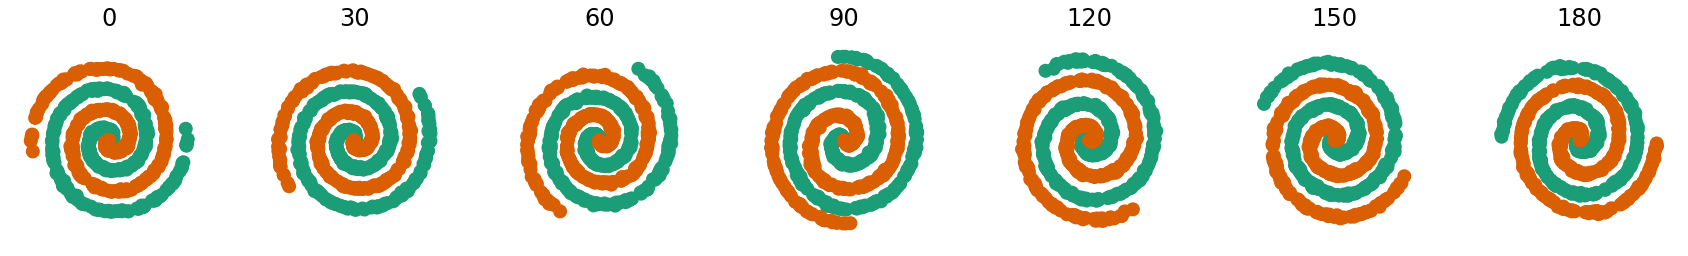

In [71]:
colors = sns.color_palette('Dark2', n_colors=5)
clr = [colors[i] for i in y_task1]
angles = [0,30,60,90,120,150,180]
fig,axs = plt.subplots(1,len(angles),figsize=(4*len(angles)+2,4))
for i,a in enumerate(angles):
    x,y = box_to_cir(rotated_spirals(750, 2, 0.1, a/180*np.pi))
    axs[i].scatter(x[:,0],x[:,1], c=clr)
    axs[i].set_xlim([-1.3, 1.3]); axs[i].set_ylim([-1.3, 1.3])
    axs[i].axis('off'); axs[i].set_title(a)

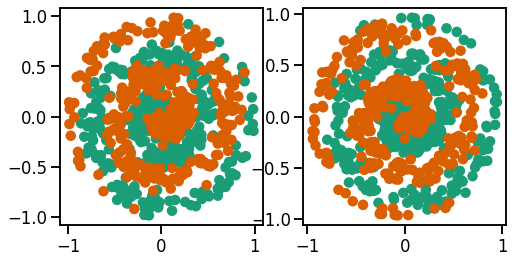

In [73]:
colors = sns.color_palette('Dark2', n_colors=5)
clr = [colors[i] for i in y_task1]
fig,axs = plt.subplots(1,2,figsize=(8,4))
axs[0].scatter(X_task1[:,0],X_task1[:,1], c=clr)
axs[1].scatter(X_task2[:,0],X_task2[:,1], c=clr)

#### run experiment

In [ ]:
start_time = time.time()
print(exp(100,100,7, task1_angle=np.pi*(15/180), task2_angle=np.pi*(65/180), ite=1000))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
rep = 1000
angle1 = 0
angle2 = 60
errors_0_75 = Parallel(n_jobs=-2, verbose=1)(
    delayed(exp)(
        100, 100, ceil(log2(100)), task1_angle=np.pi*(angle1/180), task2_angle=np.pi*(angle2/180), ite=1000
    ) for _ in range(rep)
)

In [ ]:
[np.mean(np.array(errors_0_75)[:,i]) for i in range(3)]

In [ ]:
for i in [0,1]:
    print(np.mean(np.array(errors_0_75)[:,2]) / np.mean(np.array(errors_0_75)[:,i]))

In [23]:
# errors_all = {}
pickle_in = open("errors_all-spiral-sitk-angles0_15_90-0216.pickle", "rb")
errors_all = pickle.load(pickle_in)

In [25]:
rep = 1000
angle1 = 0
# angle2 = [0, 15, 30, 45, 60, 75, 90]
angle2 = [0]

for i,a in enumerate(angle2):
    print('angle2 = %s'%a)
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(exp)(
                750, 750, task1_angle=angle1, task2_angle=np.pi*(a/180), ite=1500, res=4, scale=100
            ) for _ in range(rep)
        )
    )
    name = str(angle1)+"_"+str(a)
    errors_all[name] = error

angle2 = 0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 36.5min finished


In [26]:
print(np.mean(error[:,0]), np.mean(error[:,1]), np.mean(error[:,2]))
print(np.mean(error[:,2])/np.mean(error[:,0]), np.mean(error[:,2])/np.mean(error[:,1]))

0.09927299999999997 0.0 0.11152599999999999
1.1234273165916213 inf


/simple-elastix/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [35]:
j = errors_all['0_180']
print(np.mean(j[:,0]), np.mean(j[:,1]), np.mean(j[:,2]))
print(np.mean(j[:,2]) / np.mean(j[:,0]),np.mean(j[:,2]) / np.mean(j[:,1]))

0.10125899999999997 0.11868199999999998 0.113977
1.1255987122132356 0.9603562461030317


In [36]:
pickle_out = open("errors_all-spiral-sitk-angles0_15_90-0216.pickle", "wb")
pickle.dump(errors_all, pickle_out)
pickle_out.close()

In [41]:
pickle_in = open("errors_all-spiral-sitk-angles0_15_90-0216.pickle", "rb")
errors_all = pickle.load(pickle_in)

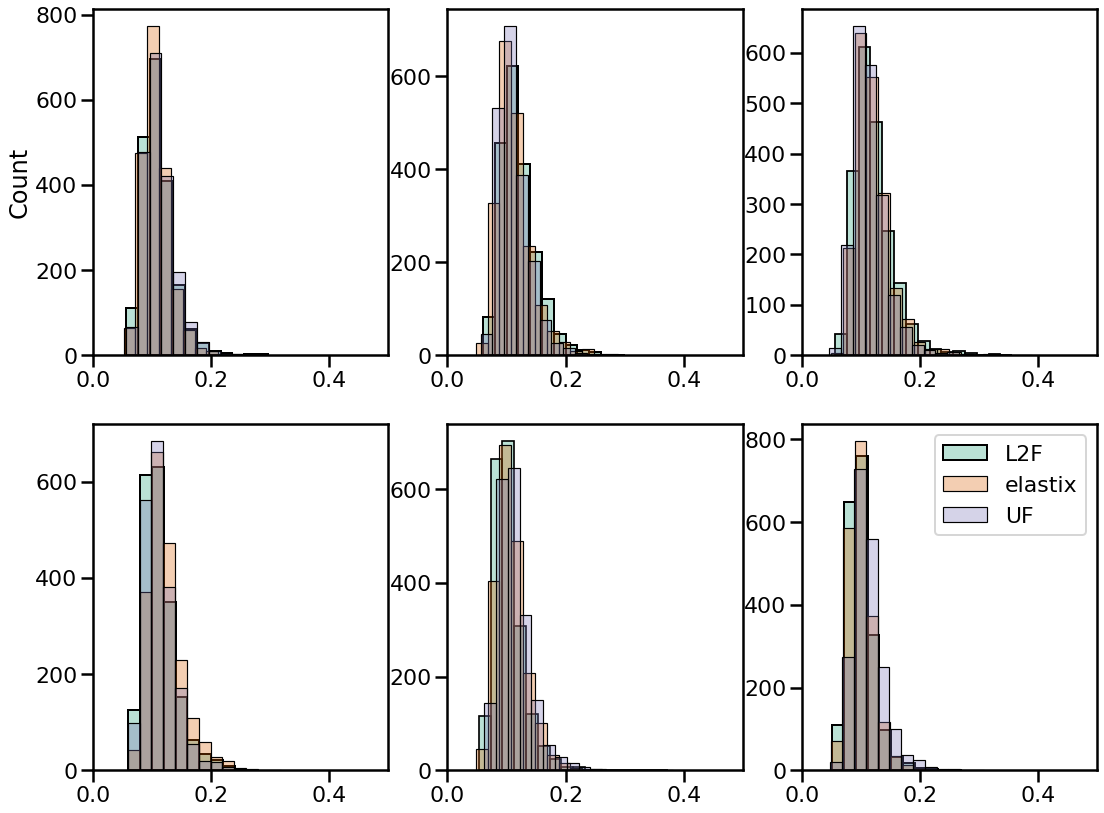

In [77]:
colors = sns.color_palette('Dark2', n_colors=6)
angles = [30,60,90,120,150,180]
algs = ['L2F','elastix','UF']
fig,axs = plt.subplots(2,3,figsize=(18,14))
for i in range(len(angles)):
    if i <=2:
        ax = axs[0,i]
    else:
        ax = axs[1,i-3]
    for j in [0,1,2]:
        sns.histplot(
            errors_all['0_'+str(angles[i])][:,j],
            alpha=0.3, color=colors[j],label=algs[j], binwidth=0.02, ax=ax
        )
        ax.set_xlim([0,0.5])
        if i != 0:
            ax.set_ylabel('')
plt.legend()

#### plot data

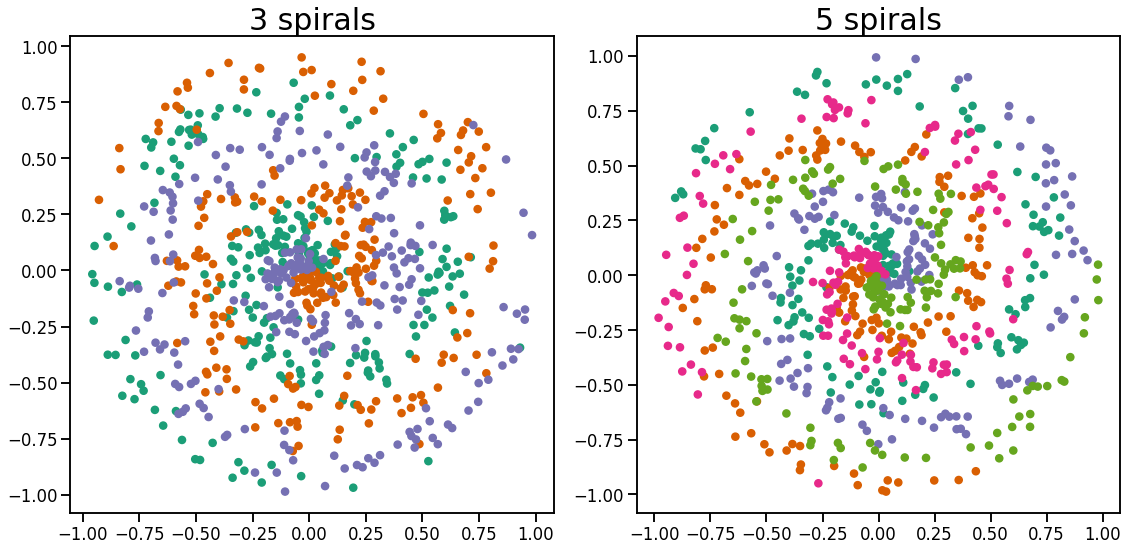

In [72]:
spiral3, y_spiral3 = generate_spirals(750, 3, noise=0.8)
spiral5, y_spiral5 = generate_spirals(750, 5, noise=0.4)

colors = sns.color_palette('Dark2', n_colors=5)

fig, ax = plt.subplots(1,2, figsize=(16,8))

clr = [colors[i] for i in y_spiral3]
ax[0].scatter(spiral3[:, 0], spiral3[:, 1], c=clr, s=50)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
ax[0].set_title('3 spirals', fontsize=30)
# ax[0].axis('off')

clr = [colors[i] for i in y_spiral5]
ax[1].scatter(spiral5[:, 0], spiral5[:, 1], c=clr, s=50)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
ax[1].set_title('5 spirals', fontsize=30)
# ax[1].axis('off')

plt.tight_layout()

In [ ]:
# j = dat["15_15"]
j = errors_all["15_60"]
[np.mean(j[:,i]) for i in range(3)]

In [ ]:
[np.mean(np.array(errors)[:,i]) for i in range(3)]

In [ ]:
for i in [0,1]:
    print(np.mean(j[:,2]) / np.mean(j[:,i]))

In [ ]:
# indices of NaNs
print(np.sum(np.isnan(errors_all_0_simple_param['0_90'])))
errors_all_0_simple_param['0_90_withNans'] = errors_all_0_simple_param['0_90']
errors_all_0_simple_param['0_90'] = errors_all_0_simple_param['0_90_withNans'][~np.isnan(errors_all_0_simple_param['0_90_withNans']).any(axis=1)]


In [ ]:
# indices of NaNs
deg1 = 0; deg2 = 75
print(np.sum(np.isnan(errors_all_0_more_param[str(deg1)+'_'+str(deg2)])))
errors_all_0_more_param[str(deg1)+'_'+str(deg2)+'_withNans'] = errors_all_0_more_param[str(deg1)+'_'+str(deg2)]
errors_all_0_more_param[str(deg1)+'_'+str(deg2)] = errors_all_0_more_param[str(deg1)+'_'+str(deg2)+'_withNans'][~np.isnan(errors_all_0_more_param[str(deg1)+'_'+str(deg2)+'_withNans']).any(axis=1)]


In [ ]:
angle_sweep = [15,30,45,60,75,90,105]
mean_te = np.empty((len(angle_sweep), 2))
for idx in range(len(angle_sweep)):
    name = "15_" + str(angle_sweep[idx])
    j = errors_all_15_simple_param[name]
    mean_te[idx, 0] = np.mean(j[:,2]) / np.mean(j[:,0])
    mean_te[idx, 1] = np.mean(j[:,2]) / np.mean(j[:,1])
    
print(mean_te)

In [27]:
angle_sweep = [0,30,60,90,120,150,180]
mean_te = np.empty((len(angle_sweep), 2))
for idx in range(len(angle_sweep)):
    name = "0_" + str(angle_sweep[idx])
    j = errors_all[name]
    mean_te[idx, 0] = np.mean(j[:,2]) / np.mean(j[:,0])
    mean_te[idx, 1] = np.mean(j[:,2]) / np.mean(j[:,1])
    
print(mean_te)

[[1.12342732        inf]
 [1.01966846 1.09550862]
 [0.93624422 1.13492103]
 [0.93205662 1.14797875]
 [1.01227851 1.09380236]
 [1.10034636 1.07719942]
 [1.12559871 0.96035625]]


/simple-elastix/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


In [46]:
errors_all_old={}

In [45]:
pickle_in = open("errors_FT-spiral-sitk-angles0_-150-180.pickle", "rb")
e3 = pickle.load(pickle_in)

In [58]:
# errors_all_3000={}
angle_sweep = [0,30,60,90,120,150,180]
for i in range(len(angle_sweep)):
    errors_all_3000['0_'+str(angle_sweep[i])] \
        = np.mean(errors_all_old['0_'+str(angle_sweep[i])],2*errors_all['0_'+str(angle_sweep[i])])

TypeError: only size-1 arrays can be converted to Python scalars

In [11]:
angle_sweep = [0,30,60,90,120,150,180]
mean_te = np.empty((len(angle_sweep), 4))
for idx in range(len(angle_sweep)):
    name = "0_" + str(angle_sweep[idx])
    j = errors_all[name]
    mean_te[idx, 0] = np.mean(j[:,3]) / np.mean(j[:,1])
    mean_te[idx, 1] = np.mean(j[:,3]) / np.mean(j[:,5])
    mean_te[idx, 2] = np.mean(j[:,2]) / np.mean(j[:,0])
    mean_te[idx, 3] = np.mean(j[:,2]) / np.mean(j[:,4])
    
print(mean_te)

[[1.12996005        inf 1.12538442        inf]
 [1.07402065 1.06308825 1.02663547 1.10355883]
 [0.98091445 0.99297205 0.93297586 1.12135026]
 [0.93763631 1.0241625  0.93408892 1.16195026]
 [0.93321328 0.97686936 1.00008845 1.10235111]
 [1.02414348 0.94999295 1.09894063 1.09459089]
 [1.12432815 0.89813166 1.12422627 1.00727681]]


/simple-elastix/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/simple-elastix/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
colors = sns.color_palette("Dark2", n_colors=2)
ax.plot(np.array(angle_sweep[:-2])-15, mean_te[:-2,0], linewidth = 3, label="L2F")
ax.plot(np.array(angle_sweep[:-2])-15, mean_te[:-2,1], linewidth = 3, label="SimpleElastix")
ax.set_xticks(range(0,91,10))
ax.set_xlabel('Task2 Net Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)
plt.legend()
plt.title('Task1 = 15deg RXOR')
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

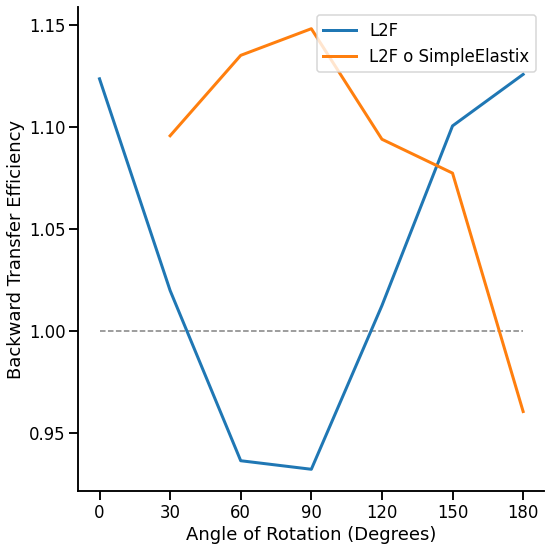

In [43]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
colors = sns.color_palette("Dark2", n_colors=2)
angle_sweep = [0,30,60,90,120,150,180]
ax.plot(np.array(angle_sweep), mean_te[:,0], linewidth = 3, label="L2F")
ax.plot(np.array(angle_sweep[1:]), mean_te[1:,1], linewidth = 3, label="L2F o SimpleElastix")
ax.set_xticks(range(0,181,30))
ax.set_xlabel('Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency')
ax.hlines(1, 0,180, colors='gray', linestyles='dashed',linewidth=1.5)
plt.legend()
# plt.title("Task1 = XOR")
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
plt.tight_layout()
plt.savefig('spiral_bte')

In [ ]:
i = 

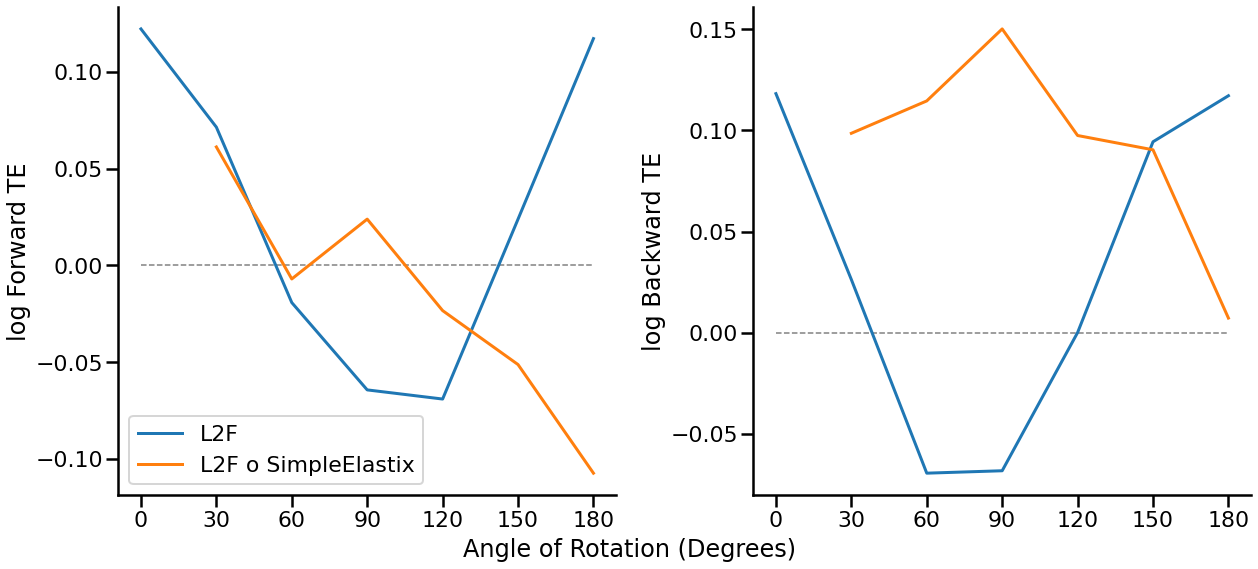

In [34]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
colors = sns.color_palette("Dark2", n_colors=2)
angle_sweep = [0,30,60,90,120,150,180]
ax = axs[0]
ax.plot(np.array(angle_sweep), np.log(mean_te[:,0]), linewidth = 3, label="L2F")
ax.plot(np.array(angle_sweep[1:]), np.log(mean_te[1:,1]), linewidth = 3, label="L2F o SimpleElastix")
ax.set_xticks(range(0,181,30)); ax.set_ylabel('log Forward TE')
ax.hlines(0, 0,180, colors='gray', linestyles='dashed',linewidth=1.5); ax.legend()
right_side = ax.spines["right"]; right_side.set_visible(False)
top_side = ax.spines["top"]; top_side.set_visible(False)
ax = axs[1]
ax.plot(np.array(angle_sweep), np.log(mean_te[:,2]), linewidth = 3, label="L2F")
ax.plot(np.array(angle_sweep[1:]), np.log(mean_te[1:,3]), linewidth = 3, label="L2F o SimpleElastix")
ax.set_xticks(range(0,181,30)); ax.set_ylabel('log Backward TE')
fig.text(0.5, 0, 'Angle of Rotation (Degrees)', ha='center')
ax.hlines(0, 0,180, colors='gray', linestyles='dashed',linewidth=1.5)
right_side = ax.spines["right"]; right_side.set_visible(False)
top_side = ax.spines["top"]; top_side.set_visible(False)
plt.tight_layout()
plt.savefig('spiral_fte_bte')